In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

We set the sampling frequency which will later be used to play audio.

In [3]:
Fs = 16000 # 16 KHz sampling rate

The above sampling frequency means that, there would be 16000 samples of data per second.

In Karplus-Strong (K-S) Algorithm, the period of the output signal is the length of the input finite signal. Say, if we have 50 samples in the input signal, then frequecy will be $$f = F_s / M$$, i.e, 16000/50, which would be $$320 Hz$$. 

Now let us choose an input signal with random values.

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


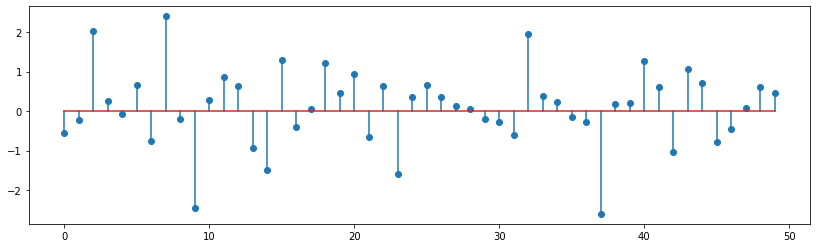

In [5]:
x_n = np.random.randn(50)
plt.stem(x_n);

Now let us define a function which returns output signal generated using K-S algorithm. Here we define the total number of output data points, as in theory, K-S algorithm generates infinite signal.

In [7]:
def KS(x, N, alpha=1):
    M = len(x)
    y = np.zeros(N)
    for n in range(0, N):
        y[n] = (x[n] if n < M else 0) + alpha * (y[n-M] if (n - M) >= 0 else 0)
    return y

In [8]:
y = KS(x_n, Fs * 2)
# Fs * 2 will generate two seconds worth of data

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


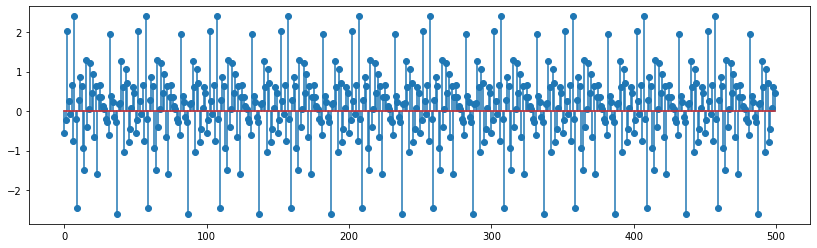

In [11]:
plt.stem(y[0:500]);  # Cause plotting the whole sequence would hang my device and plot would look clumsy

In [12]:
IPython.display.Audio(y, rate=Fs)